In [8]:
"""
A script to convert the drosophila connectome into SpineML 

This build upon the pure data to add in the required infered network components:

# Install libSpineML from source
# https://github.com/AdamRTomkins/libSpineML

"""
from __future__ import division

from libSpineML import smlExperiment as exp
from libSpineML import smlNetwork as net
from libSpineML import smlComponent as com
from libSpineML.smlUtils import  create_spineml_network
from libSpineML.smlUtils import  process_connection_json

from libSpineML.smlUtils import  extract_adjacency_matrix
from libSpineML.smlUtils import  inject_adjacency_matrix
from libSpineML.smlUtils import set_esn_weights

from matplotlib import pyplot as plt

import csv
import sys

import cStringIO
import graphviz as gv
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import copy
import pickle


N = 3

# first lets create our own false json file and lpu_dict file
lpu_dict = {'neurons':{},'populations':[]}
lpu_dict['neurons'] = {str(i):str(i) for i in np.arange(N)}
lpu_dict['population'] = {str(i):str(i) for i in np.arange(N)}

connections_json = {'nodes':{},'edges':{}}
connections_json['nodes'] = {str(i).encode('utf8') : {u'class': u'Neuron', u'name': str(i).encode('utf8') , u'uname': str(i).encode('utf8') } for i in np.arange(N)}

# create connections:
# eydentity matrix
adjacency_matrix =  -(np.eye(N,N)-1) * 0.1

for n in np.arange(adjacency_matrix.shape[0]):
    if str(n).encode('utf8') not in connections_json['edges']:
        connections_json['edges'][str(n).encode('utf8')] = {}
    for m in np.arange(adjacency_matrix.shape[1]):
        if  adjacency_matrix[n,m]!=0:
            if str(m).encode('utf8') not in connections_json['edges'][str(n).encode('utf8')]:

                connections_json['edges'][str(n).encode('utf8')][str(m).encode('utf8')] = {}

                connections_json['edges'][str(n).encode('utf8')][str(m).encode('utf8')] = {}
                connections_json['edges'][str(n).encode('utf8')][str(m).encode('utf8')] = {u'inferred': 0, u'synapses': adjacency_matrix[n,m]}

                                                                             
                                                                             #connections_json['edges'] = {str(i).encode('utf8') : {str((N-1)-i).encode('utf8') :{u'inferred': 0, u'synapses': 0.1}} for i in np.arange(N)}

In [9]:
#connections_json = pickle.load(( open( "../neuroarch_example/spineml/example_connections_json.p", "rb" ) ))
#connections#_json.keys()

In [10]:
connections_json['edges']

{'0': {'1': {u'inferred': 0, u'synapses': 0.1},
  '2': {u'inferred': 0, u'synapses': 0.1}},
 '1': {'0': {u'inferred': 0, u'synapses': 0.1},
  '2': {u'inferred': 0, u'synapses': 0.1}},
 '2': {'0': {u'inferred': 0, u'synapses': 0.1},
  '1': {u'inferred': 0, u'synapses': 0.1}}}

In [11]:
neurons, populations, projections = process_connection_json(connections_json,lpu_dict,neuron_params = None) 
print "Creating SpineML representation..."

create_spineml_network(neurons, populations,
projections,output_filename='network.xml',project_name= 'drosophila')

print "done"

Creating SpineML representation...
done


# Build an ESN implementation

We can pass in a custom neuron parameters dictionary to specify the ESN network components


In [12]:
neuron_params = {'mem_model':
                            {'name':'ESNNode', 'filename':'ESNNode.xml'},
                         'weight_update' :
                            {'name':'ESNWeight', 'filename':'ESNWeight.xml','override':{}},
                         'synapse' :
                            {'name':'ESNConnection', 'filename':'ESNConnection.xml'}
                        }

In [14]:
neurons, populations, projections = process_connection_json(connections_json,lpu_dict,neuron_params = neuron_params) 
print "Creating SpineML representation..."

create_spineml_network(neurons, populations,
projections,output_filename='ESN_files/test_esn_network.xml',project_name= 'drosophila')

print "done"

Creating SpineML representation...
done


# Overwrite Weights 

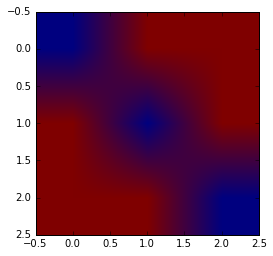

In [15]:
adjacency_matrix, neuron_index = extract_adjacency_matrix(populations,projections)
plt.imshow(adjacency_matrix)
plt.show()

In [16]:
adjacency_matrix

array([[0., 1., 1.],
       [1., 0., 1.],
       [1., 1., 0.]])

In [17]:

rand_matrix = adjacency_matrix* np.random.rand(adjacency_matrix.shape[0],adjacency_matrix.shape[1])

populations_rand,projections_rand = inject_adjacency_matrix( populations,projections, rand_matrix, neuron_index, weight_parameter='w') 

adjacency_matrix_rand, _ = extract_adjacency_matrix(populations_rand,projections_rand,weight_parameter='w')  

In [24]:
neuron_params = {'mem_model':
                            {'name':'ESNNode', 'filename':'ESNNode.xml'},
                         'weight_update' :
                            {'name':'ESNWeight', 'filename':'ESNWeight.xml','override':{}},
                         'synapse' :
                            {'name':'ESNConnection', 'filename':'ESNConnection.xml'}
                        }

neurons, populations, projections = process_connection_json(connections_json,lpu_dict,neuron_params = neuron_params) 
print "Creating SpineML representation..."


spectral_radius=1.0
print "Creating ESN weights..."

populations,projections,adjacency_matrix = set_esn_weights(populations,projections, spectral_radius=1.0,weight_parameter='w')

print "Creating SpineML Files"
create_spineml_network(neurons, populations,
projections,output_filename='ESN_files/esn_network.xml',project_name= 'drosophila')

print "Done"


Creating SpineML representation...
Creating ESN weights...
Creating SpineML Files
Done


# Create Echo State Inputs

## TODO

1. Add Input to Connection Json
2. Expand system to allow for different Model specifications from the JSON, this should allow multiple Neuron Body Types

In [25]:
# N_Inputs

# For every Input, add a ESNInput Node
# For every non-zero ESN Weight for that Input add a projection with a weight

connections_json

{'edges': {'0': {'1': {u'inferred': 0, u'synapses': 0.1},
   '2': {u'inferred': 0, u'synapses': 0.1}},
  '1': {'0': {u'inferred': 0, u'synapses': 0.1},
   '2': {u'inferred': 0, u'synapses': 0.1}},
  '2': {'0': {u'inferred': 0, u'synapses': 0.1},
   '1': {u'inferred': 0, u'synapses': 0.1}}},
 'nodes': {'0': {u'class': u'Neuron', u'name': '0', u'uname': '0'},
  '1': {u'class': u'Neuron', u'name': '1', u'uname': '1'},
  '2': {u'class': u'Neuron', u'name': '2', u'uname': '2'}}}